[ 사용한 데이터 ]
- Training file names:  ( tfrecords/train_0 ~ train_2 ).tfrecords - 약 13GB
- Validation file names: ( tfrecords/test_0 ~ test_7 ).tfrecords - 약 8GB

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

2022-03-03 13:38:21.128379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 13:38:23.966789: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6645189837649961954,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14592656064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4921922236941445854
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

2022-03-03 13:38:23.974458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-03 13:38:23.982743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 13:38:23.982927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-03 13:38:23.982944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 13:38:23.989086: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-03 13:38:23.989139: I tensorflow/stream_executor/platfo

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-03-03 13:38:29.042977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 13:38:29.043214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-03 13:38:29.043256: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 13:38:29.043300: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-03 13:38:29.043313: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-03-03 13:38:29.043325: I tensorflow/stream_executor/p

In [4]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-03-03 13:38:35.988240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 13:38:35.988464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-03 13:38:35.988495: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 13:38:35.988525: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-03 13:38:35.988538: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-03-03 13:38:35.988550: I tensorflow/stream_executor/p

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3060068551471265711,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14592656064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10973941098543348675
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [6]:
tf.random.set_seed(999)
np.random.seed(999)

In [7]:
path_to_dataset = os.getenv('HOME')+'/data/tfrecords'

In [8]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'test_*'))

# suffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)

Training file names:  ['/home/seungmiya13/data/tfrecords/train_2.tfrecords', '/home/seungmiya13/data/tfrecords/train_1.tfrecords', '/home/seungmiya13/data/tfrecords/train_0.tfrecords']
Validation file names:  ['/home/seungmiya13/data/tfrecords/test_0.tfrecords', '/home/seungmiya13/data/tfrecords/test_7.tfrecords', '/home/seungmiya13/data/tfrecords/test_1.tfrecords', '/home/seungmiya13/data/tfrecords/test_2.tfrecords', '/home/seungmiya13/data/tfrecords/test_4.tfrecords', '/home/seungmiya13/data/tfrecords/test_6.tfrecords', '/home/seungmiya13/data/tfrecords/test_3.tfrecords', '/home/seungmiya13/data/tfrecords/test_5.tfrecords']


In [9]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [10]:
mozilla_basepath = os.getenv('HOME')+ "/data/en"
UrbanSound8K_basepath = os.getenv('HOME')+ '/data/UrbanSound8K'

## Prepare Input features

In [11]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

## Create tf.Data.Dataset

In [13]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-03-03 13:39:02.936561: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-03 13:39:02.936850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 13:39:02.937061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-03 13:39:02.937100: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 13:39:02.937137: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-03 13:39:02.937148: I tensorflow/stream_executor/platform/de

In [14]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

## Model Training

In [15]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [18]:
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
    x = Activation('relu')(x)
    if use_bn:
        x = BatchNormalization()(x)
    return x

In [19]:
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
    shortcut = x
    in_channels = x.shape[-1]

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

    return shortcut + x

In [21]:
def build_model(l2_strength):
    inputs = Input(shape=[numFeatures,numSegments,1])
    x = inputs

    # -----
    x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
    x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # -----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip1
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip0
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(3e-4) # lr = 3e-4
    #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

    model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
    return model

In [22]:
model = build_model(l2_strength=0.0)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 129, 1, 18)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [23]:
# You might need to install the following dependencies: sudo apt install python-pydot python-pydot-ng graphviz
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [20]:
import wandb

wandb.init(project="cnn-audio-denoiser", entity="seungmiya13")

wandb: Currently logged in as: seungmiya13 (use `wandb login --relogin` to force relogin)
2022-03-03 13:39:36.796645: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [24]:
wandb.config = {
  "learning_rate": 3e-4,
  "epochs": 400,
  "batch_size": 512
}

In [25]:
from wandb.keras import WandbCallback

In [26]:
baseline_val_loss = model.evaluate(test_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

2022-03-03 13:40:12.626528: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-03 13:40:12.627100: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
2022-03-03 13:40:13.026798: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-03-03 13:40:14.192577: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-03-03 13:40:14.291901: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2210/2210 [==============================] - 72s 32ms/step - loss: 0.6352 - rmse: 0.7970
Baseline accuracy 0.6346789598464966


In [ ]:
%tensorboard --logdir logs

In [27]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised, cleaned, eps=1e-7): # Signal to Distortion Ratio
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [28]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)

# wandb.tensorflow.log()

model.fit(train_dataset,
         steps_per_epoch=600, # you might need to change this
         validation_data=test_dataset,
         epochs=400,
         callbacks=[early_stopping_callback, WandbCallback()]
        )

2022-03-03 13:41:36.546962: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-03-03 13:41:36.547012: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-03-03 13:41:36.547054: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2022-03-03 13:41:36.551789: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2022-03-03 13:41:36.652328: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-03-03 13:41:36.652743: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/400
600/600 [==============================] - 83s 136ms/step - loss: 0.3853 - rmse: 0.6207 - val_loss: 0.2489 - val_rmse: 0.4989
Epoch 2/400
600/600 [==============================] - 85s 141ms/step - loss: 0.2306 - rmse: 0.4802 - val_loss: 0.2088 - val_rmse: 0.4569
Epoch 3/400
600/600 [==============================] - 84s 139ms/step - loss: 0.2101 - rmse: 0.4584 - val_loss: 0.2027 - val_rmse: 0.4502
Epoch 4/400
600/600 [==============================] - 81s 135ms/step - loss: 0.2005 - rmse: 0.4478 - val_loss: 0.1987 - val_rmse: 0.4458
Epoch 5/400
600/600 [==============================] - 80s 133ms/step - loss: 0.1906 - rmse: 0.4365 - val_loss: 0.1976 - val_rmse: 0.4445
Epoch 6/400
600/600 [==============================] - 80s 134ms/step - loss: 0.1870 - rmse: 0.4325 - val_loss: 0.1956 - val_rmse: 0.4423
Epoch 7/400
600/600 [==============================] - 80s 133ms/step - loss: 0.1815 - rmse: 0.4260 - val_loss: 0.1811 - val_rmse: 0.4256
Epoch 8/400
600/600 [=============

600/600 [==============================] - 74s 124ms/step - loss: 0.1458 - rmse: 0.3818 - val_loss: 0.1629 - val_rmse: 0.4036
Epoch 61/400
600/600 [==============================] - 74s 123ms/step - loss: 0.1457 - rmse: 0.3817 - val_loss: 0.1619 - val_rmse: 0.4024
Epoch 62/400
600/600 [==============================] - 74s 123ms/step - loss: 0.1497 - rmse: 0.3869 - val_loss: 0.1734 - val_rmse: 0.4164
Epoch 63/400
600/600 [==============================] - 74s 123ms/step - loss: 0.1471 - rmse: 0.3835 - val_loss: 0.1615 - val_rmse: 0.4019
Epoch 64/400
600/600 [==============================] - 77s 129ms/step - loss: 0.1478 - rmse: 0.3845 - val_loss: 0.1647 - val_rmse: 0.4059
Epoch 65/400
600/600 [==============================] - 74s 124ms/step - loss: 0.1463 - rmse: 0.3825 - val_loss: 0.1650 - val_rmse: 0.4063
Epoch 66/400
600/600 [==============================] - 76s 127ms/step - loss: 0.1475 - rmse: 0.3841 - val_loss: 0.1716 - val_rmse: 0.4143
Epoch 67/400
600/600 [==================

Epoch 119/400
600/600 [==============================] - 73s 122ms/step - loss: 0.1418 - rmse: 0.3766 - val_loss: 0.1620 - val_rmse: 0.4025
Epoch 120/400
600/600 [==============================] - 74s 123ms/step - loss: 0.1421 - rmse: 0.3770 - val_loss: 0.1639 - val_rmse: 0.4048
Epoch 121/400
600/600 [==============================] - 74s 123ms/step - loss: 0.1443 - rmse: 0.3799 - val_loss: 0.1620 - val_rmse: 0.4024
Epoch 122/400
600/600 [==============================] - 74s 124ms/step - loss: 0.1406 - rmse: 0.3750 - val_loss: 0.1607 - val_rmse: 0.4008
Epoch 123/400
600/600 [==============================] - 73s 122ms/step - loss: 0.1430 - rmse: 0.3781 - val_loss: 0.1588 - val_rmse: 0.3985
Epoch 124/400
600/600 [==============================] - 73s 122ms/step - loss: 0.1415 - rmse: 0.3761 - val_loss: 0.1594 - val_rmse: 0.3992
Epoch 125/400
600/600 [==============================] - 74s 124ms/step - loss: 0.1411 - rmse: 0.3756 - val_loss: 0.1567 - val_rmse: 0.3959
Epoch 126/400
600/60

600/600 [==============================] - 74s 124ms/step - loss: 0.1363 - rmse: 0.3691 - val_loss: 0.1605 - val_rmse: 0.4006
Epoch 236/400
600/600 [==============================] - 74s 123ms/step - loss: 0.1371 - rmse: 0.3703 - val_loss: 0.1586 - val_rmse: 0.3982
Epoch 237/400
600/600 [==============================] - 74s 124ms/step - loss: 0.1402 - rmse: 0.3744 - val_loss: 0.1606 - val_rmse: 0.4008
Epoch 238/400
600/600 [==============================] - 73s 122ms/step - loss: 0.1377 - rmse: 0.3710 - val_loss: 0.1663 - val_rmse: 0.4077
Epoch 239/400
600/600 [==============================] - 74s 124ms/step - loss: 0.1386 - rmse: 0.3723 - val_loss: 0.1591 - val_rmse: 0.3989
Epoch 240/400
600/600 [==============================] - 76s 127ms/step - loss: 0.1380 - rmse: 0.3715 - val_loss: 0.1576 - val_rmse: 0.3970
Epoch 241/400
600/600 [==============================] - 73s 122ms/step - loss: 0.1377 - rmse: 0.3710 - val_loss: 0.1562 - val_rmse: 0.3952
Epoch 242/400
600/600 [===========

In [29]:
val_loss = model.evaluate(test_dataset)[0]
if val_loss < baseline_val_loss:
  print("New model saved.")
  model.save('./denoiser_cnn_log_mel_generator.h5')

2210/2210 [==============================] - 70s 32ms/step - loss: 0.1517 - rmse: 0.3895
New model saved.


## Testing

In [30]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [31]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                           n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length, hop_length=self.overlap,
                                             win_length=self.window_length, window=self.window,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [32]:
cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'test', 'clean_sample.wav'), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

Min: -0.3333333 Max: 0.30261758


In [33]:
noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'test', '7913-3-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

Min: -0.2916928 Max: 0.33333334


In [34]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 3.0009497e-09 Max: 11.036943


In [35]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

In [36]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [37]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 436)


In [38]:
predictors = prepare_input_features(noise_stft_features)

In [39]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (436, 129, 8, 1)


In [40]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

(436, 129, 1, 1)


In [41]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [42]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -0.23926671 Max: 0.2656372


In [43]:
# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

Text(0.5, 1.0, 'Denoised Audio')

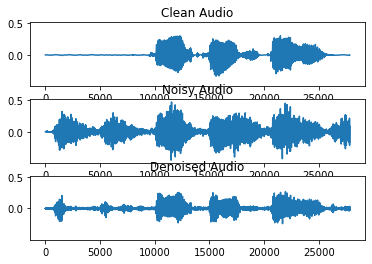

In [44]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")